In [386]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

In [387]:
user_risk_factor = 1

min_volatility = 0.05
max_volatility = 0.30
desired_volatility = min_volatility + (max_volatility - min_volatility) * (user_risk_factor - 1) / 9

In [388]:
tickers = ['MSFT', 'CAT', 'GILD', 'ECL', 'DLR', 'EFX', 'TTWO', 'ARE', 'DPZ', 'FFIV']
end_date = datetime(year=2021, month=12, day = 31)
#end_date = datetime.today()
start_date = end_date - timedelta(days = 2*365)


In [389]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date)
    adj_close_df[ticker] = data['Adj Close']


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [390]:
print(adj_close_df)

                  MSFT         CAT       GILD         ECL         DLR  \
Date                                                                    
2020-01-02  154.493805  136.412827  55.354561  182.024963  102.128670   
2020-01-03  152.570099  134.518845  55.218781  181.154205  103.807716   
2020-01-06  152.964478  134.428192  55.710976  179.613647  102.872986   
2020-01-07  151.569809  132.652023  55.261208  179.384003  101.860359   
2020-01-08  153.984039  133.830124  55.838264  179.450974  102.743164   
...                ...         ...        ...         ...         ...   
2021-12-23  328.062073  196.512253  66.739052  222.408630  156.485077   
2021-12-27  335.668396  196.683807  67.098175  225.751007  159.885513   
2021-12-28  334.492157  196.912521  67.190247  228.148163  161.138824   
2021-12-29  335.178314  197.589172  67.807175  229.619583  161.507401   
2021-12-30  332.600372  196.397919  67.549347  228.031219  162.272308   

                   EFX        TTWO         ARE    

In [391]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

In [392]:
log_returns = log_returns.dropna()

In [393]:
log_returns

,MSFT,CAT,GILD,ECL,DLR,EFX,TTWO,ARE,DPZ,FFIV
Date,,,,,,,,,,
2020-01-03,-0.012530,-0.013981,-0.002456,-0.004795,0.016307,0.003365,0.001064,0.005681,0.004319,-0.005414
2020-01-06,0.002582,-0.000674,0.008874,-0.008540,-0.009045,0.004260,0.020090,0.002425,-0.002446,-0.012579
2020-01-07,-0.009159,-0.013301,-0.008106,-0.001279,-0.009892,-0.001883,0.006555,-0.033274,-0.007169,-0.009156
2020-01-08,0.015803,0.008842,0.010388,0.000373,0.008629,0.021210,0.018238,0.013202,-0.004430,-0.004023
2020-01-09,0.012416,-0.002509,0.000608,0.013242,0.000084,0.011555,0.001564,-0.003554,-0.005730,-0.003304
...,...,...,...,...,...,...,...,...,...,...
2021-12-23,0.004462,0.019837,0.000690,0.006197,-0.009378,0.012727,0.001912,-0.007051,0.020377,0.016876
2021-12-27,0.022921,0.000873,0.005367,0.014916,0.021497,0.014080,0.008951,0.011286,0.020616,0.035473
2021-12-28,-0.003510,0.001162,0.001371,0.010563,0.007808,0.009947,-0.000947,0.008550,0.001004,0.013836


In [394]:
cov_matrix = log_returns.cov() * 252

In [395]:
cov_matrix

,MSFT,CAT,GILD,ECL,DLR,EFX,TTWO,ARE,DPZ,FFIV
MSFT,0.119046,0.053612,0.035910,0.070801,0.064245,0.063179,0.064265,0.072138,0.041875,0.060738
CAT,0.053612,0.135113,0.035481,0.085019,0.040587,0.057368,0.019365,0.057308,0.011088,0.055760
GILD,0.035910,0.035481,0.087845,0.037487,0.030388,0.025130,0.021282,0.030459,0.016469,0.020071
ECL,0.070801,0.085019,0.037487,0.137130,0.059540,0.072878,0.029292,0.075137,0.023251,0.063722
DLR,0.064245,0.040587,0.030388,0.059540,0.118144,0.056110,0.038502,0.077149,0.019760,0.034825
EFX,0.063179,0.057368,0.025130,0.072878,0.056110,0.128662,0.033765,0.064030,0.024102,0.045623
TTWO,0.064265,0.019365,0.021282,0.029292,0.038502,0.033765,0.133190,0.036850,0.042438,0.031234
ARE,0.072138,0.057308,0.030459,0.075137,0.077149,0.064030,0.036850,0.107271,0.027612,0.052143
DPZ,0.041875,0.011088,0.016469,0.023251,0.019760,0.024102,0.042438,0.027612,0.119926,0.028357
FFIV,0.060738,0.055760,0.020071,0.063722,0.034825,0.045623,0.031234,0.052143,0.028357,0.120995


In [396]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate, desired_volatility, risk_aversion=50):
    port_return = expected_return(weights, log_returns)
    port_volatility = standard_deviation(weights, cov_matrix)
    # Penalty for deviation from desired volatility
    penalty = risk_aversion * (port_volatility - desired_volatility) ** 2
    return (port_return - risk_free_rate) / port_volatility - penalty

In [397]:
risk_free_rate = .02

def objective_function(weights, log_returns, cov_matrix, risk_free_rate, desired_volatility):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate, desired_volatility)


constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.5) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

optimized_results = minimize(objective_function, initial_weights, args=(log_returns, cov_matrix, risk_free_rate, desired_volatility), method='SLSQP', constraints=constraints, bounds=bounds)


In [398]:
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")

Optimal Weights:
MSFT: 0.0774
CAT: 0.0232
GILD: 0.1410
ECL: 0.0000
DLR: 0.0830
EFX: 0.2054
TTWO: 0.0417
ARE: 0.0000
DPZ: 0.2845
FFIV: 0.1438
Expected Annual Return: 0.2848
Expected Volatility: 0.2200


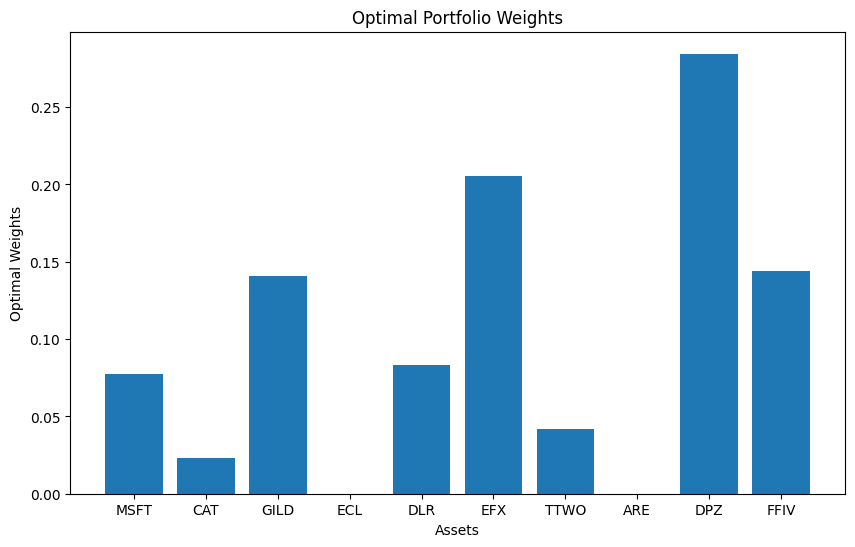

In [399]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()